### Importation et configuration du notebook

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
import os
import pickle
import sys

sys.path.insert(0, os.path.abspath('..'))

import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
layers = keras.layers
mnist = keras.datasets.mnist
import tensorflow_probability as tfp
tfd = tfp.distributions

from recast.distributions import *
from recast.etas import *
from recast.model import *

sns.set_style('whitegrid')

### Fonctions d'assistance

In [217]:
def poisson(T: float, mu: float) -> list[float]:
    """Génère un processus de Poisson homogène."""
    N = np.random.poisson(mu * T)
    return np.sort(np.random.uniform(0, T, size=N))


def poisson_inh(T: float, mu: float = 1) -> list[float] | None:
    """Génère un processus de Poisson inhomogène."""
    intensity = lambda t: 1 + np.sin(0.1 * t)
    x = np.linspace(0, T, 1000)
    sup = np.max(intensity(x))

    times = np.array([-1 / mu * np.log(np.random.uniform())])

    while times[-1] < T:
        tau = -1 / mu * np.log(np.random.uniform())
        next_time = times[-1] + tau
        D = np.random.uniform()
        if D <= intensity(next_time) / sup:
            times = np.append(times, next_time)

    return times[times <= T]


def intensity(t: float, seq: np.ndarray, mu: float = 1,
              alpha: float = 2, beta: float = 2.3) -> float:
        return mu + np.sum(alpha * np.exp(-beta * (t - seq[seq < t])))


def hawkes(mu: float = 1, alpha: float = 1, beta: float = 2,
           T: float = 100) -> list[float] | None:
    """Génère un processus de Hawkes."""
    times = np.array([-1 / mu * np.log(np.random.uniform())])

    if times.size == 0:
        return None

    while times[-1] < T:
        lambd_bar = intensity(times[-1], times, mu, alpha, beta)
        tau = -1 / lambd_bar * np.log(np.random.uniform())
        next_time = times[-1] + tau
        D = np.random.uniform()
        if D * lambd_bar <= intensity(next_time, times, mu, alpha, beta):
            times = np.append(times, next_time)

    return times[times <= T]


def cmp_dist(model: Model, seq: np.ndarray, start: int,
             ylim: tuple[float, float] = (0, 1)) -> None:
    """Compare les distributions ETAS et RECAST."""
    sub_seq = seq[:start]
    t = sub_seq[:, 0]
    m = sub_seq[:, 1]
    recast_dist = model.predict(t, m, 1, True)[1][0]
    etas_dist = ETAS(t, m)
    fig, axes = plt.subplots(2, 1, sharex='col', sharey='col', figsize=(6, 3))
    x = np.linspace(0, 3, 1000)
    axes[0].plot(x, recast_dist.prob(x), label='RECAST')
    axes[1].plot(x, etas_dist.prob(x), label='ETAS')
    axes[1].set_ylim(ylim)
    plt.show()


def plot_etas_seq(seq: pd.DataFrame, n: int = 0,
                  dpi: Optional[int] = None) -> None:
    """Affiche la séquence et les n plus grandes magnitudes."""
    fig, ax = plt.subplots(figsize=(6, 4), dpi=dpi)
    ax.plot(seq.time, seq.index + 1)
    high_mags_idx = seq.magnitude.sort_values(ascending=False).index[:n]
    for idx in high_mags_idx:
        t = seq.time.iloc[idx]
        m = seq.magnitude.iloc[idx]
        ax.scatter(t, idx + 1, label=f'{m:.2f}', marker='.', s=100)
        ax.vlines(t, 0, idx + 1, linestyle='--', alpha=0.5, colors='black')
    if n:
        ax.legend(loc='upper left', ncol=2)
    plt.show()


def get_seq(generated_data: np.ndarray, seq_lengths: np.ndarray,
            i: int) -> pd.DataFrame:
    """Retourne un tableau pandas qui contient les données générées."""
    arrival_times = generated_data[i, :seq_lengths[i], 0]
    magnitudes = generated_data[i, :seq_lengths[i], 1]
    seq = pd.DataFrame({'time': arrival_times, 'magnitude': magnitudes})
    return seq


def plot_seqs(seqs: list[np.ndarray]):
    for seq in seqs:
        plt.plot(seq[:, 0], np.cumsum(np.ones(seq.shape[0])))
    plt.show()


def cumsum(arr: np.ndarray) -> np.ndarray:
    return np.cumsum(np.ones_like(arr))


def predict_and_plot(model: Model, seq: np.ndarray, n_before: int,
                     n_after: Optional[int] = None,
                     dpi: Optional[int] = None) -> np.ndarray:
    """Affiche la nouvelle séquence avec les données prédites."""
    n_preds = n_after if n_after else n_before
    past_seq = seq[:-n_before]
    t = past_seq[:, 0]
    m = past_seq[:, 1]
    preds = model.predict(t, m, n_preds)
    t_preds = preds[:, 0]
    m_preds = preds[:, 1]
    seq_size = seq.shape[0]
    last_idx_target = min(seq_size - 1, seq_size - n_before + n_preds)
    t_targets = seq[-n_before:last_idx_target, 0]

    fig, ax = plt.subplots(dpi=dpi)
    ax.plot(t, cumsum(t), label='Séquence passée')
    ax.plot(t_preds, t.size + cumsum(t_preds), label='Prédictions', alpha=0.6)
    ax.plot(t_targets, t.size + cumsum(t_targets), label='Cibles', alpha=0.6)
    ax.axhline(y=t.size, linestyle='--', c='black', alpha=0.7)
    ax.legend()
    plt.show()

    new_seq = np.concatenate([past_seq[:, :2], preds], 0)
    return new_seq


def get_dist_at_epoch(i: int, dists: list[Mixture],
                      dist: Distribution = Weibull) -> Mixture:
    weights, params = dists[i].params
    weights = weights[0, 250]
    b = params[..., 0][0, 250]
    k = params[..., 1][0, 250]
    return Mixture(weights, dist(b, k))


def sgd(F, x_train, y_train, theta_0, lr, n_step):
    grad_F = jax.grad(F, argnums=1)

    thetas = [theta_0]

    for t in range(n_step):
        idx = np.random.randint(len(x_train))
        y_pred = F(x_train[idx], theta_0)
        loss = (y_train[idx] - y_pred) ** 2
        grads = grad_F(loss, theta_0)
        theta_0 -= lr * grads
        thetas.append(theta_0)

    return thetas


def data_generation():
    a, b = 3.3, -3.1

    def true_f(x):
        return x * jnp.exp(-(x - b) ** 2 /2 ) + jnp.exp(-(x - a) ** 2 / 2)

    n = 500
    x_train = np.random.uniform(low=-10, high=10, size=n)
    y_train = true_f(x_train) + 0.1 * np.random.randn(n)
    
    return x_train, y_train


def plot_sgd(F, x_train, y_train, thetas):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    fig.tight_layout()

    thetas = np.array(thetas)

    ax = axes[0]

    ax.plot(thetas[:, 0], thetas[:, 1], zorder=1)
    ax.scatter(thetas[0, 0], thetas[0, 1], c='blue', s=40,
               label='Départ', zorder=2, marker='v')
    ax.scatter(thetas[-1][0], thetas[-1][1], c='red', s=40,
               label='Arrivée', zorder=2, marker='^')
    ax.scatter([3.3], [-3.1], label='Objectif', c='green', s=40, marker='>')
    ax.legend()
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')

    xs = np.linspace(-10, 10, 500)

    ax = axes[1]
    ax.scatter(x_train, y_train, s=5, c='C0', alpha=0.5)
    ax.plot(xs, F(xs, thetas[0]), c='C1', linewidth=3,
            linestyle='--', label='Modèle')
    ax.set_title(r'Modèle initial (avec $\theta^0$)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = axes[2]
    ax.scatter(x_train, y_train, s=5, c='C0', alpha=0.5)
    ax.plot(xs, F(xs, thetas[-1]), c='C1', linewidth=3,
            linestyle='--')
    ax.set_title(r'Modèle final (avec $\theta^T$)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    left_patch = mlines.Line2D([], [], color='C0', label='Cibles',
                               linestyle='', marker='o')
    right_patch = mpatches.Patch(color='C1', label='Modèle')
    fig.legend(handles=[left_patch, right_patch], bbox_to_anchor=[0.78, 0],
               ncol=2)


def F(x, theta):
    a = theta[0]
    b = theta[1]
    return x * jnp.exp(-(x - b) ** 2 / 2) + jnp.exp(-(x - a) ** 2 / 2)

### Les processus ponctuels temporels

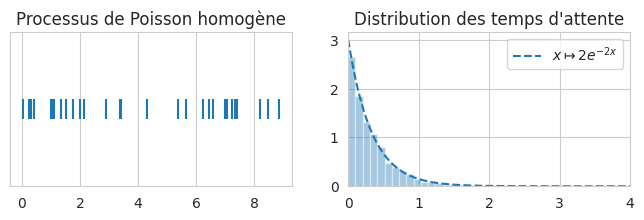

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))

mu = 3
data = poisson(T = 1000, mu=3)

num_samples = 30
axes[0].scatter(data[:num_samples], np.ones(num_samples),
                marker='|', c='C0', s=200)
axes[0].set_yticks([], [])
axes[0].set_title('Processus de Poisson homogène')

diff = np.diff(data, prepend=0)
axes[1].hist(diff, density=True, alpha=0.4, bins=30)
xlim = (0, 4)
axes[1].set_xlim(xlim)
x = np.linspace(0, xlim[-1], 1000)
axes[1].plot(x, mu * np.exp(-mu * x), c='C0', linestyle='--',
             label='$x \\mapsto 2e^{-2x}$')
axes[1].set_title('Distribution des temps d\'attente')

plt.legend()
plt.savefig('../images/poisson_process.png', bbox_inches='tight',
            transparent=True)

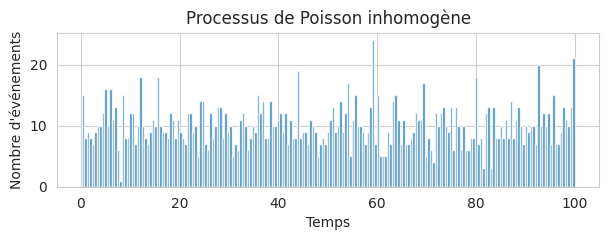

In [ ]:
T = 100
mu = 20
seq = poisson_inh(T, mu)
plt.figure(figsize=(7, 2))
plt.hist(seq, bins=seq.size // 10, alpha=0.8, color='C0')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson inhomogène')
plt.savefig('../images/poisson_inh.png', bbox_inches='tight', transparent=True)

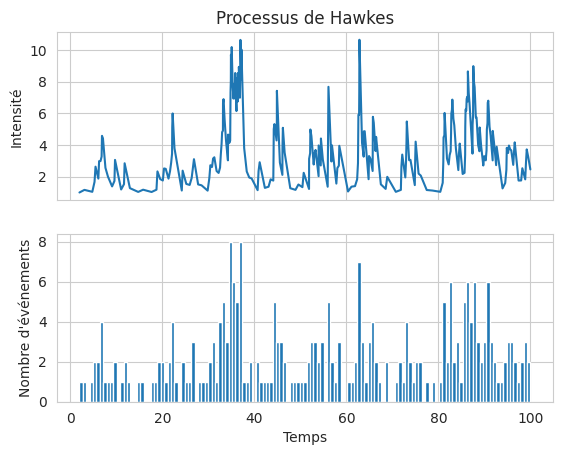

In [ ]:
T = 100
alpha = 1
beta = 2
seq = hawkes(alpha=1, beta=2, T=T)
intensities = [intensity(s, seq) for s in seq]

# plt.figure(figsize=(8, 3))
# plt.plot(seq, intensities)
# plt.show()

fig, axes = plt.subplots(2, 1, sharex='col')
axes[0].plot(seq, intensities)
axes[0].set_ylabel('Intensité')
axes[0].set_title('Processus de Hawkes')
axes[1].hist(seq, bins=seq.size // 2)
axes[1].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
plt.savefig('../images/hawkes.png', bbox_inches='tight', transparent=True)

### Le modèle ETAS

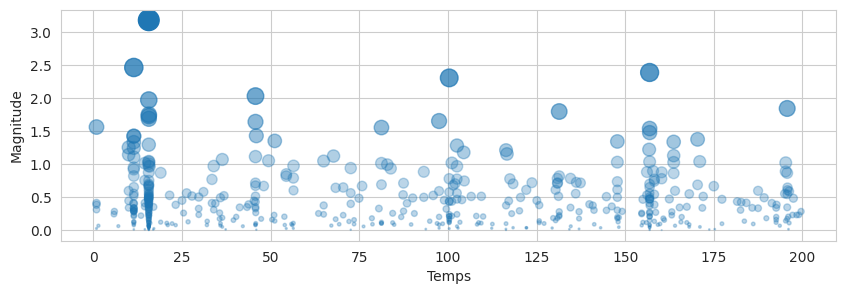

In [76]:
seq = etas(t_end=200)
frame = to_frame(seq)
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(frame.time, frame.magnitude, s=frame.magnitude * 70,
                alpha=np.maximum(.3, frame.magnitude / frame.magnitude.max()))
plt.xlabel('Temps')
plt.ylabel('Magnitude')
plt.savefig('../images/etas_mag.png', bbox_inches='tight', dpi=150)
plt.show()

In [25]:
seq = etas(t_end=3000)
frame = to_frame(seq)
frame.iloc[:10, :2]

,time,magnitude
0,0.639224,1.604289
1,0.639224,0.409295
2,0.639226,0.125361
3,0.639356,0.370638
4,0.639874,0.464503
5,0.639877,0.006245
6,0.649052,0.254912
7,0.748794,0.721520
8,2.600925,0.010425
9,3.530178,0.031414


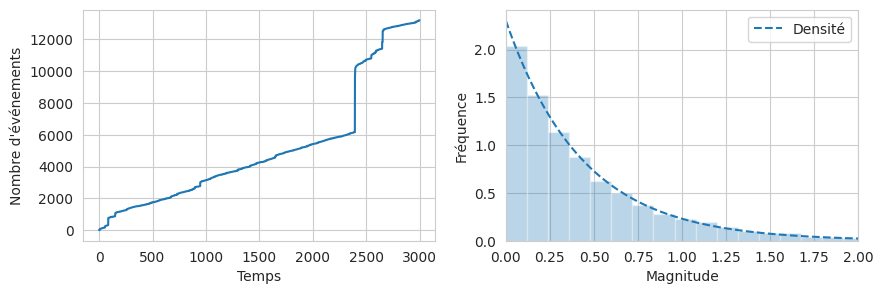

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(frame.time, frame.index + 1)
axes[0].set_xlabel('Temps')
axes[0].set_ylabel('Nombre d\'événements')
axes[1].hist(frame.magnitude, bins=40, density=True, alpha=0.3)
axes[1].set_xlim([0, 2])
x = np.linspace(0, 2, 1000)
y = np.log(10) * np.exp(-np.log(10) * x)
axes[1].plot(x, y, color='C0', label='Densité', linestyle='--')
axes[1].set_xlabel('Magnitude')
axes[1].set_ylabel('Fréquence')
axes[1].legend()
plt.savefig('../images/hist_etas.png', bbox_inches='tight', dpi=150)
plt.show()

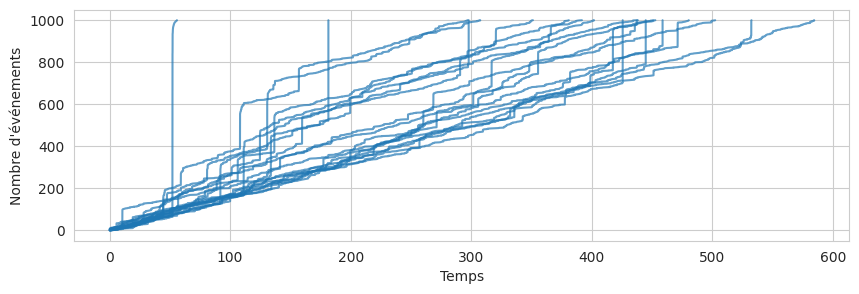

In [27]:
seqs = []
num_seqs = 20
plt.figure(figsize=(10, 3))
for k in range(num_seqs):
    seq = etas(max_len=1000)
    seqs.append(seq)
    plt.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1), c='C0', alpha=0.7)
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.savefig('../images/batch_etas.png', bbox_inches='tight', dpi=150)

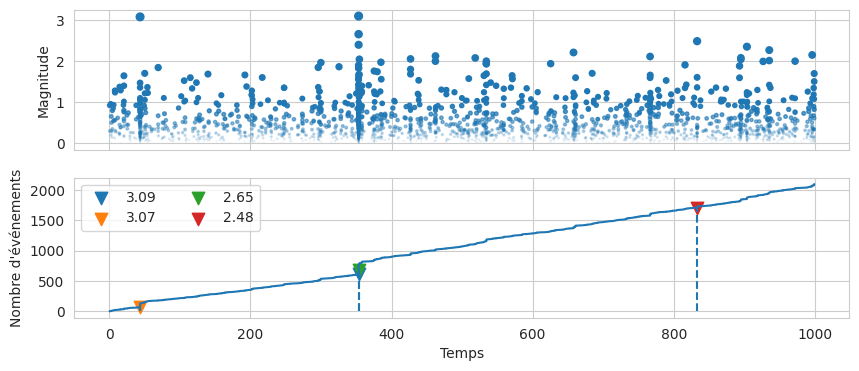

In [ ]:
# On peut visualiser l'influence de la magnitude sur le nombre d'événements.

seq = etas(t_end=1000)
frame = to_frame(seq)
high_mags_idx = frame.magnitude.sort_values(ascending=False).index[:4]
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex='col')
axes[0].scatter(frame.time, frame.magnitude, s=frame.magnitude * 10,
                alpha=np.clip(frame.magnitude, 0, 1))
axes[1].plot(frame.time, frame.index + 1)
for idx in high_mags_idx:
    t = frame.time.iloc[idx]
    m = frame.magnitude.iloc[idx]
    axes[1].vlines(t, 0, idx, cmap=plt.cm.binary, linestyle='--')
    axes[1].scatter(t, idx, s=80, label=round(m, 2), marker='v')
axes[1].set_xlabel('Temps')
axes[0].set_ylabel('Magnitude')
axes[1].set_ylabel('Nombre d\'événements')
axes[1].legend(ncol=2)
plt.savefig('../images/etas_sequence.png', dpi=150, bbox_inches='tight')
plt.show()

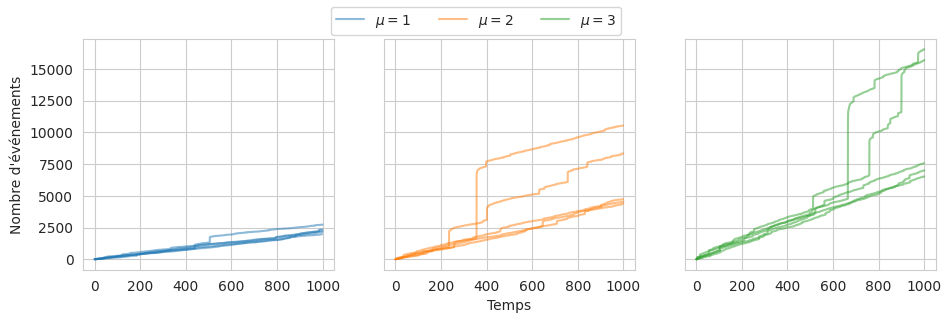

In [ ]:
mu = [1, 2, 3]
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(11, 3))
for i, (m, ax) in enumerate(zip(mu, axes)):
    for j in range(5):
        label=f'$\\mu = {m}$' if j == 0 else None
        seq = etas(t_end=1000, mu=m)
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1),
                label=label, c=f'C{i}', alpha=0.5)
axes[0].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
fig.legend(loc='upper center', ncol=3)
plt.savefig('../images/mu_etas.png', bbox_inches='tight', dpi=150)

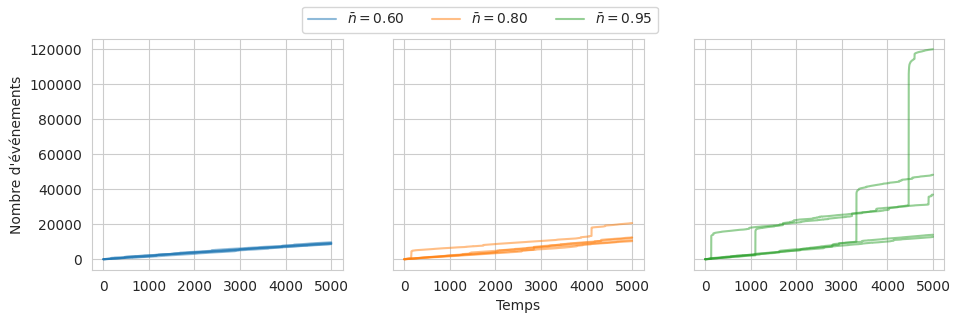

In [ ]:
bar_n = [0.6, 0.8, 0.95]
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(11, 3))
for i, (b, ax) in enumerate(zip(bar_n, axes)):
    for j in range(5):
        label = f'$\\bar{{n}} = {b:.2f}$' if j == 0 else None
        seq = etas(t_end=5000, bar_n=b)
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1),
                label=label, c=f'C{i}', alpha=0.5)
axes[0].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
fig.legend(loc='upper center', ncol=3)
plt.savefig('../images/bar_n_etas.png', bbox_inches='tight', dpi=150)

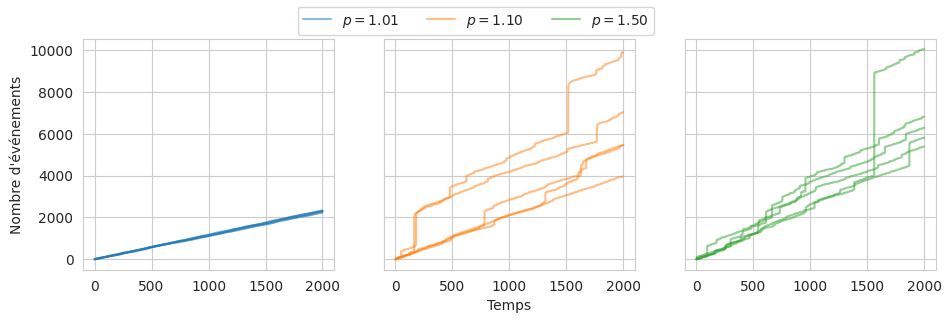

In [ ]:
pl = [1.01, 1.1, 1.5]
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(11, 3))
for i, (p, ax) in enumerate(zip(pl, axes)):
    for j in range(5):
        label = f'$p = {p:.2f}$' if j == 0 else None
        seq = etas(t_end=2000, p=p)
        ax.plot(seq[:, 0], np.arange(1, seq.shape[0] + 1),
                label=label, c=f'C{i}', alpha=0.5)

axes[0].set_ylabel('Nombre d\'événements')
axes[1].set_xlabel('Temps')
fig.legend(loc='upper center', ncol=3)
plt.savefig('p_etas.png', bbox_inches='tight', dpi=150)

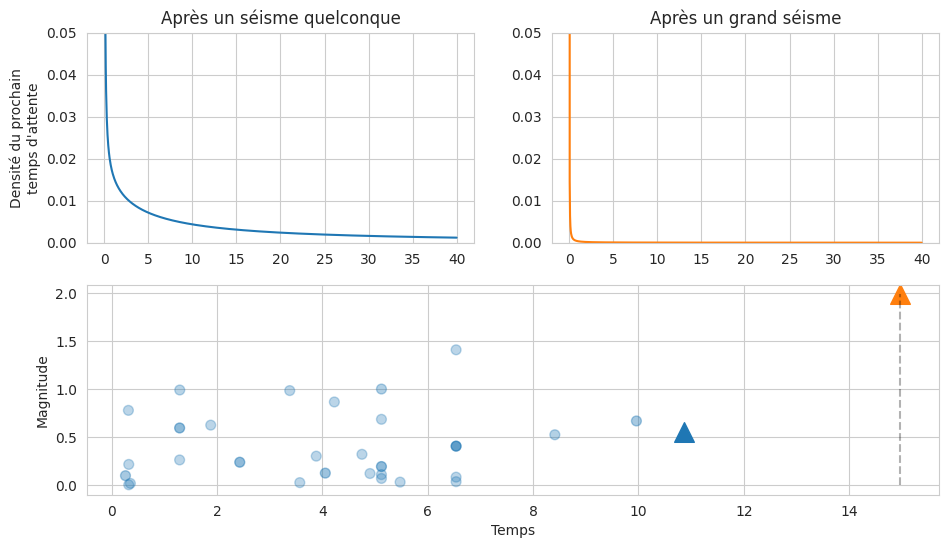

In [ ]:
seq = to_frame(etas(t_end=100))
idx = seq.magnitude.sort_values(ascending=False).iloc[:5].sort_index().index
first_mag_idx = idx[0]

fig, axes = plt.subplot_mosaic([['left', 'right'], ['bottom', 'bottom']],
                               figsize=(11, 6))

subset = seq.iloc[:first_mag_idx + 1]
t = subset.time.to_numpy()
m = subset.magnitude.to_numpy()

dist_0 = ETAS(t[:-1], m[:-1])
pdf_0 = dist_0.density
x = np.linspace(0, 40, 1000)
axes['left'].plot(x, pdf_0(x), c='C0')
axes['left'].set_ylim([0, 0.05])
axes['left'].set_ylabel('Densité du prochain\ntemps d\'attente')
axes['left'].set_title('Après un séisme quelconque')

dist_1 = ETAS(t, m)
pdf_1 = dist_1.density
axes['right'].plot(x, pdf_1(x), c='C1')
axes['right'].set_title('Après un grand séisme')

axes['right'].sharex(axes['left'])
axes['right'].sharey(axes['left'])

n_before = 100
size = 50
size_le = size * 4
marker = '^'

axes['bottom'].scatter(t[-n_before:-2], m[-n_before:-2],
                       s=size, alpha=np.maximum(0.3, m[-30:-2] / np.max(m)))
axes['bottom'].vlines(t[-1], 0, m[-1],
                      linestyle='--', colors='black', alpha=0.3)
axes['bottom'].scatter(t[-1], m[-1], c='C1', s=size_le, marker=marker)
axes['bottom'].scatter(t[-2], m[-2], c='C0', s=size_le, marker=marker)
axes['bottom'].set_ylabel('Magnitude')
axes['bottom'].set_xlabel('Temps')

plt.savefig('../images/etas_dist.png', bbox_inches='tight', dpi=150)

### Les réseaux de neurones

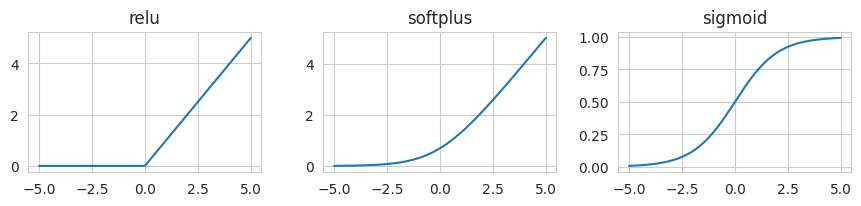

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2))
fig.tight_layout()
x = np.linspace(-5, 5, 1000)
axes[0].plot(x, keras.activations.relu(x))
axes[0].set_title('relu')
axes[1].plot(x, keras.activations.softplus(x))
axes[1].set_title('softplus')
axes[2].plot(x, keras.activations.sigmoid(x))
axes[2].set_title('sigmoid')
plt.savefig('../images/activations.png', bbox_inches='tight', dpi=150)
plt.show()

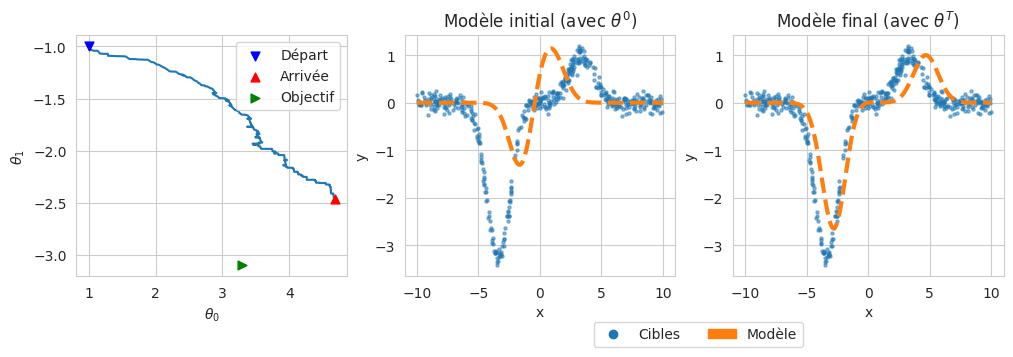

In [218]:
x_train, y_train = data_generation()
thetas = sgd(F, x_train, y_train, theta_0 = jnp.array([1., -1.]),
             lr=0.1, n_step=1000)
plot_sgd(F, x_train, y_train, thetas)
plt.savefig('../images/sgd.png', dpi=200, bbox_inches='tight')

In [220]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape, test_images.shape, train_labels.shape)

(60000, 28, 28) (10000, 28, 28) (60000,)


In [221]:
x_train = train_images.astype('float32') / 255
x_test = test_images.astype('float32') / 255

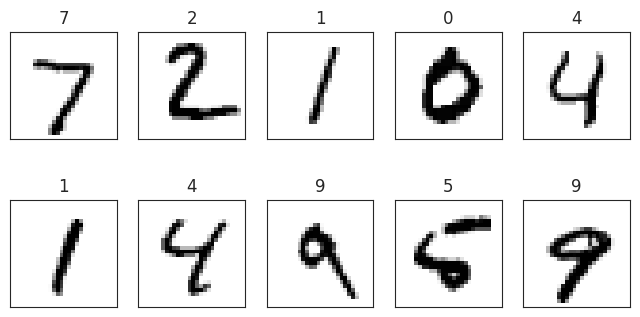

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(test_images[i], cmap=plt.cm.binary)
    ax.set_title(test_labels[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('../images/mnist.png', bbox_inches='tight', dpi=150)
plt.show()

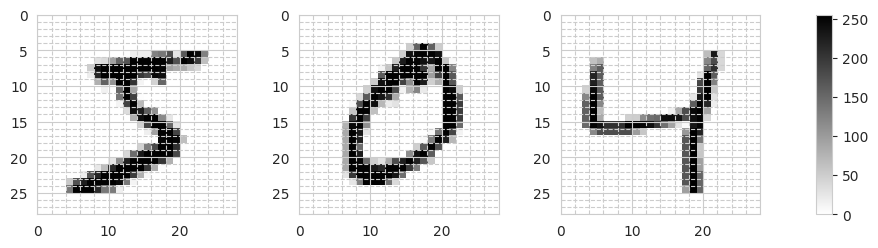

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
fig.tight_layout()
for i, ax in enumerate(axes.ravel()):
    im = ax.imshow(train_images[i], cmap=plt.cm.binary,
                    extent=(0, 28, 28, 0))
    ax.grid(which='minor', linestyle='--')
    ax.minorticks_on()
cax = fig.add_axes([axes[2].get_position().x1 + 0.07,
                    axes[2].get_position().y0,
                    0.02,
                    axes[2].get_position().y1 - axes[2].get_position().y0])
plt.colorbar(im, cax=cax)
plt.savefig('../images/image_encoding.png', bbox_inches='tight', dpi=150)
plt.show()
sns.set_style('whitegrid')

In [222]:
model = keras.Sequential([layers.Flatten(),
                          layers.Dense(512, activation='relu'),
                          layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, train_labels, epochs=15, batch_size=128,
                    validation_data=(x_test, test_labels), verbose=0)

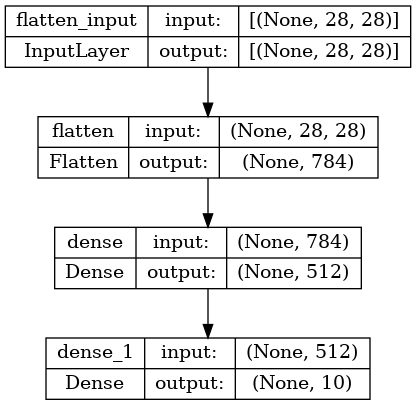

In [ ]:
keras.utils.plot_model(model, show_shapes=True, to_file='../images/model.png')

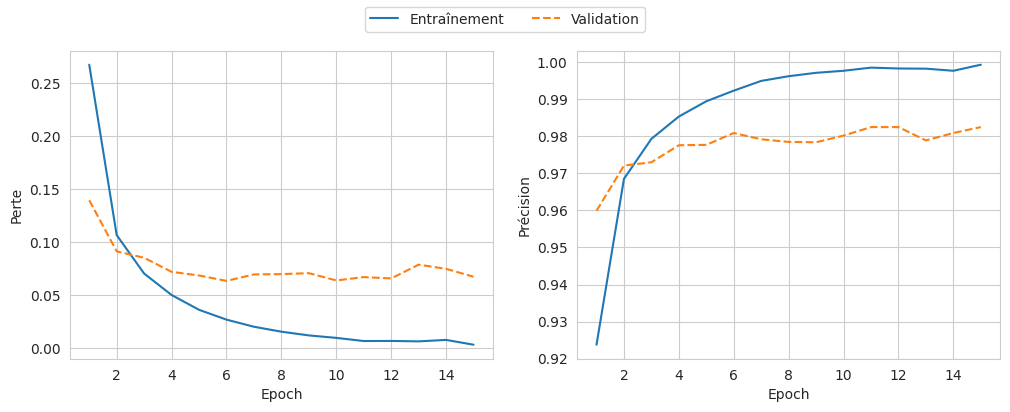

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(epochs, loss, label='Entraînement')
axes[0].plot(epochs, val_loss, label='Validation', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Perte')
axes[1].plot(epochs, accuracy)
axes[1].plot(epochs, val_accuracy, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Précision')
fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/mnist_history.png', bbox_inches='tight', dpi=150)
plt.show()

### Application aux processus ponctuels temporels

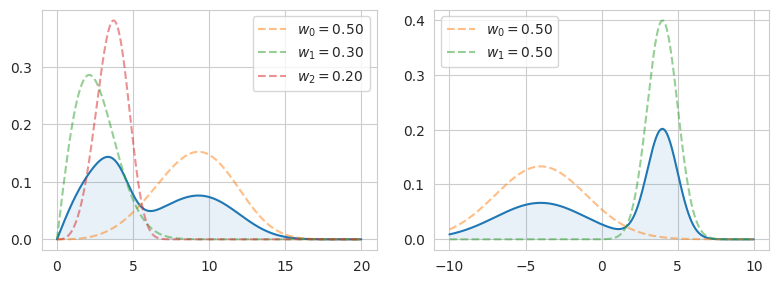

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout()

mix = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.3, 0.2]),
    components_distribution=tfd.Weibull(
        concentration=[4, 2, 4], scale=[10, 3, 4]
    )
)

cp1 = tfd.Weibull(4, 10)
cp2 = tfd.Weibull(2, 3)
cp3 = tfd.Weibull(4, 4)

x = np.linspace(0, 20, 1000)
axes[0].plot(x, mix.prob(x))
for i, d in enumerate([cp1, cp2, cp3]):
    axes[0].plot(x, d.prob(x), alpha=0.5, linestyle="--",
             label=f"$w_{i} = {mix.mixture_distribution.probs[i]:.2f}$")
axes[0].fill_between(x, 0, mix.prob(x), alpha=0.1)
axes[0].legend()

mix = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
    components_distribution=tfd.Normal(
        loc=[-4, 4], scale=[3, 1]
    )
)

cp1 = tfd.Normal(-4, 3)
cp2 = tfd.Normal(4, 1)

x = np.linspace(-10, 10, 1000)
axes[1].plot(x, mix.prob(x))
for i, d in enumerate([cp1, cp2]):
    axes[1].plot(x, d.prob(x), alpha=0.5, linestyle="--",
             label=f"$w_{i} = {mix.mixture_distribution.probs[i]:.2f}$")
axes[1].fill_between(x, 0, mix.prob(x), alpha=0.1)
axes[1].legend()

plt.savefig("../images/mixtures.png", dpi=200, bbox_inches="tight")

In [ ]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    batch_size=1, t_end=500
)
print(seqs[0].shape)
etas_log_like = log_likelihood(seqs[0], t_end)
print(etas_log_like)


(1221, 3)
13.513204087410966


In [ ]:
model = Model(R=10, learning_rate=1e-3, strategy='log_tau')
history = model.fit(inter_times, seq_lengths,
                    t_end, 500, magnitudes, verbose=1)

Loss at epoch    1:   -8.768
Loss at epoch   10:  -10.243
Loss at epoch   20:  -11.161
Loss at epoch   30:  -11.630
Loss at epoch   40:  -11.940
Loss at epoch   50:  -12.169
Loss at epoch   60:  -12.317
Loss at epoch   70:  -12.438
Loss at epoch   80:  -12.528
Loss at epoch   90:  -12.603
Loss at epoch  100:  -12.668
Loss at epoch  110:  -12.727
Loss at epoch  120:  -12.780
Loss at epoch  130:  -12.827
Loss at epoch  140:  -12.867
Loss at epoch  150:  -12.903
Loss at epoch  160:  -12.935
Loss at epoch  170:  -12.964
Loss at epoch  180:  -12.992
Loss at epoch  190:  -13.020
Loss at epoch  200:  -13.047
Loss at epoch  210:  -13.074
Loss at epoch  220:  -13.098
Loss at epoch  230:  -13.121
Loss at epoch  240:  -13.143
Loss at epoch  250:  -13.160
Loss at epoch  260:  -13.174
Loss at epoch  270:  -13.190
Loss at epoch  280:  -13.205
Loss at epoch  290:  -13.219
Loss at epoch  300:  -13.233
Loss at epoch  310:  -13.246
Loss at epoch  320:  -13.258
Loss at epoch  330:  -13.270
Loss at epoch 

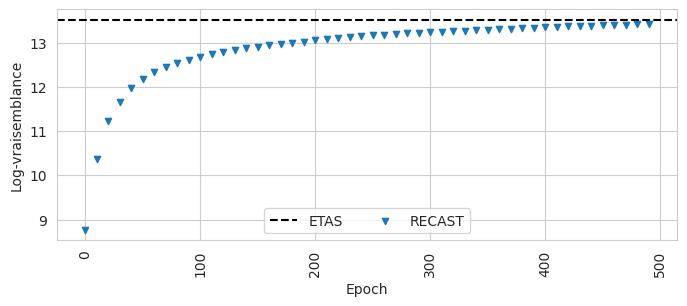

In [ ]:
recast_log_like = -np.array(history['loss'])[::10]
x = range(len(recast_log_like))
plt.figure(figsize=(8, 3))
plt.axhline(y=etas_log_like, linestyle='--', c='black', label='ETAS')
plt.scatter(x, recast_log_like, label='RECAST', marker='v', s=20)
plt.legend(ncol=2, loc='lower center')
plt.ylabel('Log-vraisemblance')
plt.xticks(ticks=range(0, 51, 10), labels=range(0, 501, 100), rotation=90)
plt.xlabel('Epoch')
plt.savefig('../images/log_like_cvg.png', bbox_inches='tight', dpi=150)
plt.show()

Loss at epoch    1:    1.715
Loss at epoch   10:    0.608
Loss at epoch   20:    0.199
Loss at epoch   30:    0.149
Loss at epoch   40:    0.120
Loss at epoch   50:    0.115
Loss at epoch   60:    0.115
Loss at epoch   70:    0.113
Loss at epoch   80:    0.112
Loss at epoch   90:    0.111
Loss at epoch  100:    0.111


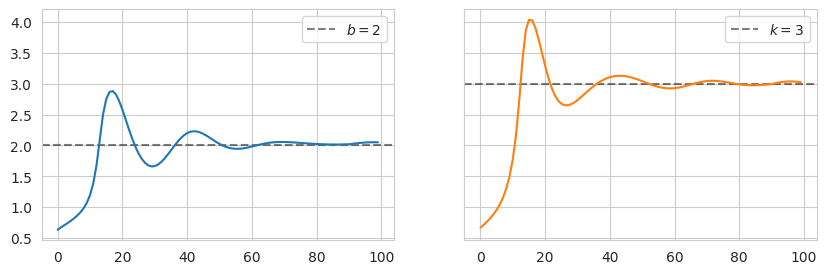

In [ ]:
# On entraîne un moèle sur un jeu de données et on 
# récupère les distributions obtenues à chaque epoch (les données
# suivent une loi de Weibull).

b = 2
k = 3
arrival_times = np.cumsum(Weibull(b, k).sample([100, 150]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Weibull, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=100,
                    return_distributions=True, verbose=1)

distributions = history['distributions']
params = [d.params[1] for d in distributions]
params = np.squeeze(np.stack(params, 0), -2)

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(10, 3))

axes[0].axhline(y=b, label=f'$b = {b}$', c='black', linestyle='--', alpha=0.5)
axes[0].legend()
axes[1].axhline(y=k, label=f'$k = {k}$', c='black', linestyle='--', alpha=0.5)
axes[1].legend()

num_epochs = len(distributions)
last_idx = enumerate(seq_lengths)

b_mean_per_epoch = [np.mean(params[i, ..., 0][range(100), seq_lengths])
                    for i in range(num_epochs)]
axes[0].plot(range(num_epochs), b_mean_per_epoch, c='C0')

k_mean_per_epoch = [np.mean(params[i, ..., 1][range(100), seq_lengths])
                      for i in range(num_epochs)]
axes[1].plot(range(num_epochs), k_mean_per_epoch, c='C1')

plt.savefig('../images/weibull_cvg.png', bbox_inches='tight', dpi=150)
plt.show()

Loss at epoch    1:    1.105
Loss at epoch   10:    0.803
Loss at epoch   20:    0.755
Loss at epoch   30:    0.732
Loss at epoch   40:    0.730
Loss at epoch   50:    0.727
Loss at epoch   60:    0.730
Loss at epoch   70:    0.726
Loss at epoch   80:    0.726
Loss at epoch   90:    0.725
Loss at epoch  100:    0.725


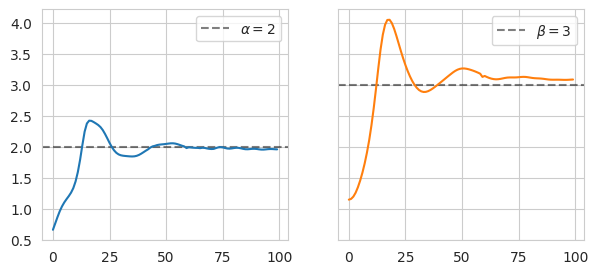

In [ ]:
# On refait la même chose avec des données qui suivent une loi Gamma.

alpha = 2
beta = 3
arrival_times = np.cumsum(tfd.Gamma(alpha, beta).sample([300, 250]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Gamma, R=1)
history = model.fit(inter_times, seq_lengths, t_end, epochs=100,
                    return_distributions=True, verbose=1)

distributions = history['distributions']
params = [d.params[1] for d in distributions]
params = np.squeeze(np.stack(params, 0), -2)

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(7, 3))

axes[0].axhline(y=alpha, label=f'$\\alpha = {alpha}$',
                linestyle='--', c='black', alpha=0.5)
axes[0].legend()
axes[1].axhline(y=beta, label=f'$\\beta = {beta}$',
                linestyle='--', c='black', alpha=0.5)
axes[1].legend()

num_epochs = len(distributions)
last_idx = list(enumerate(seq_lengths))

alpha_mean_per_epoch = [np.mean(params[i, ..., 0][last_idx])
                    for i in range(num_epochs)]
axes[0].plot(range(num_epochs), alpha_mean_per_epoch, c='C0')

beta_mean_per_epoch = [np.mean(params[i, ..., 1][last_idx])
                      for i in range(num_epochs)]
axes[1].plot(range(num_epochs), beta_mean_per_epoch, c='C1')

plt.savefig('../images/gamma_cvg.png', bbox_inches='tight', dpi=150)
plt.show()

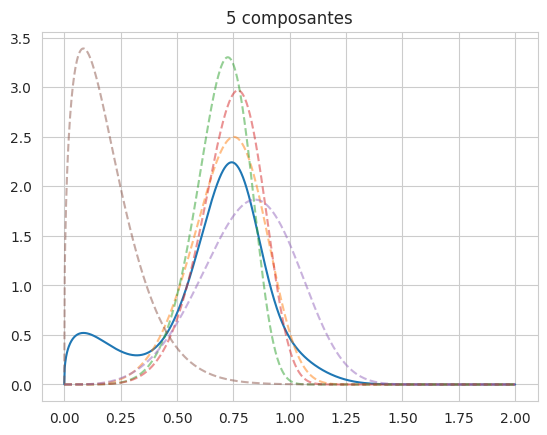

In [ ]:
n_comp = np.random.randint(3, 10)
weights = tf.nn.softmax(np.random.uniform(size=n_comp))
b = np.random.uniform(0.5, 9, size=n_comp)
k = np.random.uniform(0.5, 9, size=n_comp)
mix = Mixture(weights, Weibull(b, k))
comps = Weibull(b, k)

x = np.linspace(0, 2, 1000)
plt.plot(x, mix.prob(x))
plt.plot(x, comps.prob(x[..., tf.newaxis]), linestyle='--', alpha=0.5)
plt.title(f'{weights.shape[0]} composantes')
plt.savefig('../images/mixture_weibull.png', bbox_inches='tight')
plt.show()

In [ ]:
tau = mix.sample(251)
t = np.cumsum(tau)
t_end = t[-1]
t = t[:-1]

model = Model(32, dist=Weibull, R=10, strategy='tau_log_tau')
history = model.fit([tau], [t.size], t_end, 200, return_distributions=True)

Loss at epoch    1:    1.572
Loss at epoch   10:    0.713
Loss at epoch   20:    0.145
Loss at epoch   30:   -0.102
Loss at epoch   40:   -0.114
Loss at epoch   50:   -0.134
Loss at epoch   60:   -0.136
Loss at epoch   70:   -0.140
Loss at epoch   80:   -0.143
Loss at epoch   90:   -0.147
Loss at epoch  100:   -0.150
Loss at epoch  110:   -0.154
Loss at epoch  120:   -0.158
Loss at epoch  130:   -0.163
Loss at epoch  140:   -0.169
Loss at epoch  150:   -0.176
Loss at epoch  160:   -0.183
Loss at epoch  170:   -0.191
Loss at epoch  180:   -0.200
Loss at epoch  190:   -0.211
Loss at epoch  200:   -0.145


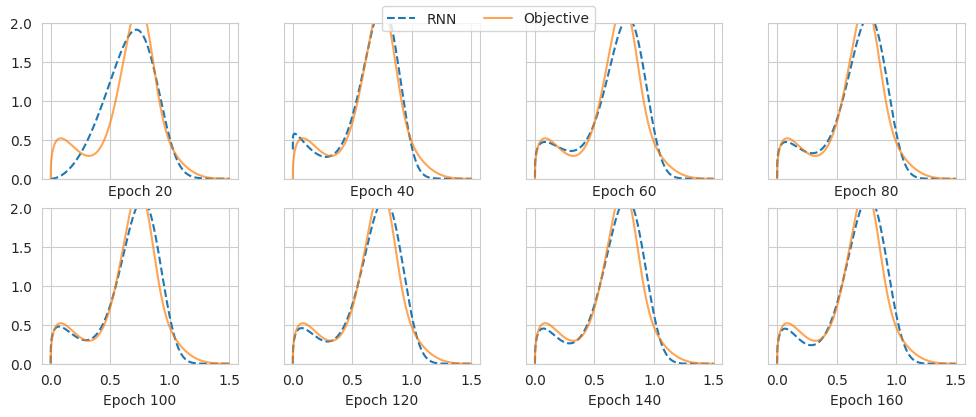

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.tight_layout()
dists = history['distributions']
i = 0
x = np.linspace(0, 1.5, 1000)
for j, ax in enumerate(axes.ravel()):
    i += 20
    recast_dist = get_dist_at_epoch(i - 1, dists)
    label1 = 'RNN' if j == 1 else None
    label2 = 'Objective' if j == 1 else None
    ax.plot(x, recast_dist.prob(x), linestyle='--', label=label1)
    ax.plot(x, mix.prob(x), alpha=0.7, label=label2)
    ax.set_xlabel(f'Epoch {i}')
    ax.set_ylim((0, 2))
fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/mix_1.png', bbox_inches='tight', dpi=150)
plt.show()

In [168]:
n_comp = np.random.randint(3, 10)
weights = tf.nn.softmax(np.random.uniform(size=n_comp))
b = np.random.uniform(0.5, 9, size=n_comp)
k = np.random.uniform(0.5, 9, size=n_comp)
mix = Mixture(weights, Gamma(b, k))

In [ ]:
tau = mix.sample(501)
t = np.cumsum(tau)
t_end = t[-1]
t = t[:-1]

model = Model(32, dist=Gamma, R=1, strategy='tau_log_tau')
history = model.fit([tau], [t.size], t_end, 200, return_distributions=True)

Loss at epoch    1:    1.270
Loss at epoch   10:    0.865
Loss at epoch   20:    0.628
Loss at epoch   30:    0.604
Loss at epoch   40:    0.595
Loss at epoch   50:    0.594
Loss at epoch   60:    0.592
Loss at epoch   70:    0.591
Loss at epoch   80:    0.590
Loss at epoch   90:    0.590
Loss at epoch  100:    0.589
Loss at epoch  110:    0.588
Loss at epoch  120:    0.587
Loss at epoch  130:    0.586
Loss at epoch  140:    0.584
Loss at epoch  150:    0.582
Loss at epoch  160:    0.578
Loss at epoch  170:    0.574
Loss at epoch  180:    0.568
Loss at epoch  190:    0.561
Loss at epoch  200:    0.555


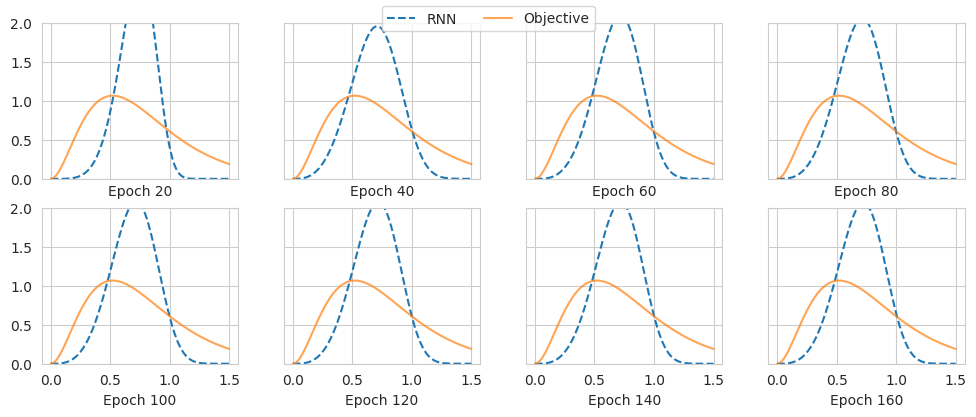

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.tight_layout()
dists = history['distributions']
i = 0
x = np.linspace(0, 1.5, 1000)
for j, ax in enumerate(axes.ravel()):
    i += 20
    recast_dist = get_dist_at_epoch(i - 1, dists)
    label1 = 'RNN' if j == 1 else None
    label2 = 'Objective' if j == 1 else None
    ax.plot(x, recast_dist.prob(x), linestyle='--', label=label1)
    ax.plot(x, mix.prob(x), alpha=0.7, label=label2)
    ax.set_xlabel(f'Epoch {i}')
    ax.set_ylim((0, 2))
fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/mix_1.png', bbox_inches='tight', dpi=150)
plt.show()

In [170]:
# Le jeu de données est utilisé par Oleksandr Shchur dans son exemple.

with open('../data/shchur.pkl', 'rb') as f:
    inter_times, seq_lengths, t_end = pickle.load(f)
model = Model(C=32, dist=Weibull, R=1)
history = model.fit(inter_times, seq_lengths, t_end, 200, verbose=1)
model.save('../models/shchur_1_weibull.pkl')

Loss at epoch    1:    1.221
Loss at epoch   10:    0.820
Loss at epoch   20:    0.815
Loss at epoch   30:    0.808
Loss at epoch   40:    0.798
Loss at epoch   50:    0.792
Loss at epoch   60:    0.786
Loss at epoch   70:    0.781
Loss at epoch   80:    0.776
Loss at epoch   90:    0.772
Loss at epoch  100:    0.767
Loss at epoch  110:    0.763
Loss at epoch  120:    0.755
Loss at epoch  130:    0.738
Loss at epoch  140:    0.746
Loss at epoch  150:    0.737
Loss at epoch  160:    0.730
Loss at epoch  170:    0.726
Loss at epoch  180:    0.723
Loss at epoch  190:    0.737
Loss at epoch  200:    0.736


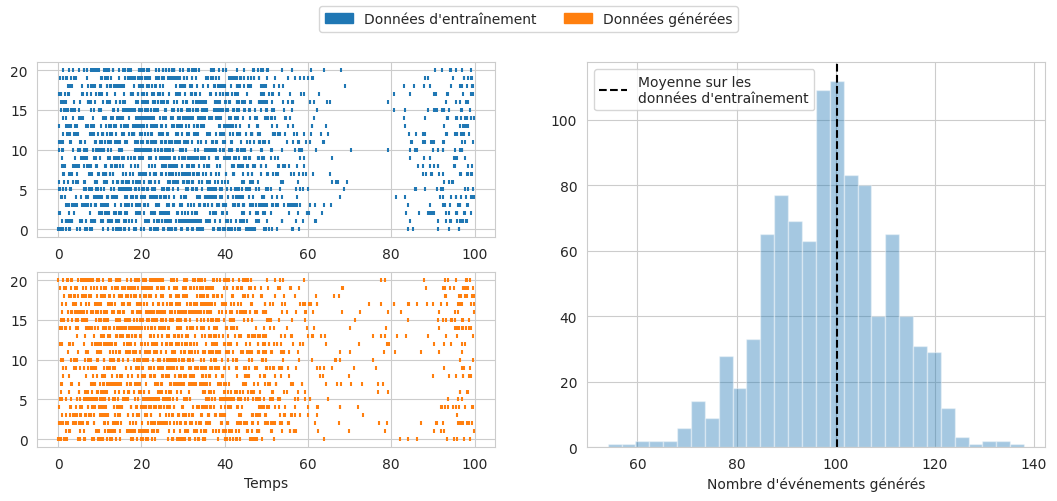

In [169]:
with open('../data/shchur.pkl', 'rb') as f:
    inter_times, seq_lengths, t_end = pickle.load(f)
model = Model.load('../models/shchur_1_weibull.pkl')

arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(1000, t_end)

fig, axes = plt.subplot_mosaic([['top', 'right'], ['bottom', 'right']],
                               figsize=(13, 5))
for i, seq in enumerate(arrival_times):
    t = seq[:seq_lengths[i]]
    axes['top'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C0')
    if i == 20:
        break
left_patch = mpatches.Patch(color='C0', label='Données d\'entraînement')

for i, seq in enumerate(gen_arrival_times):
    t = seq[:gen_seq_lengths[i]]
    axes['bottom'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C1')
    if i == 20:
        break
right_patch = mpatches.Patch(color='C1', label='Données générées')

axes['right'].hist(gen_seq_lengths, bins=30, alpha=0.4)
axes['right'].axvline(x=np.mean(seq_lengths), color='black', linestyle='--',
                      label='Moyenne sur les\ndonnées d\'entraînement')
axes['right'].legend(loc='upper left')
axes['top'].sharex(axes['bottom'])
axes['bottom'].set_xlabel('Temps')
axes['right'].set_xlabel('Nombre d\'événements générés')
fig.legend(handles=[left_patch, right_patch], loc='upper center', ncol=2)
plt.savefig('../images/gen_data_1_weibull.png', dpi=150, bbox_inches='tight')

In [14]:
inter_times, seq_lengths, t_end = pickle.load(open('../data/shchur.pkl', 'rb'))
model = Model(C=32, dist=Gamma, R=3)
history = model.fit(inter_times, seq_lengths, t_end, 200, verbose=1)
model.save('../models/shchur_3_gamma.pkl')

Loss at epoch    1:    0.920
Loss at epoch   10:    0.807
Loss at epoch   20:    0.781
Loss at epoch   30:    0.770
Loss at epoch   40:    0.763
Loss at epoch   50:    0.760
Loss at epoch   60:    0.753
Loss at epoch   70:    0.742
Loss at epoch   80:    0.730
Loss at epoch   90:    0.723
Loss at epoch  100:    0.721
Loss at epoch  110:    0.715
Loss at epoch  120:    0.714
Loss at epoch  130:    0.714
Loss at epoch  140:    0.712
Loss at epoch  150:    0.710
Loss at epoch  160:    0.710
Loss at epoch  170:    0.710
Loss at epoch  180:    0.709
Loss at epoch  190:    0.715
Loss at epoch  200:    0.710


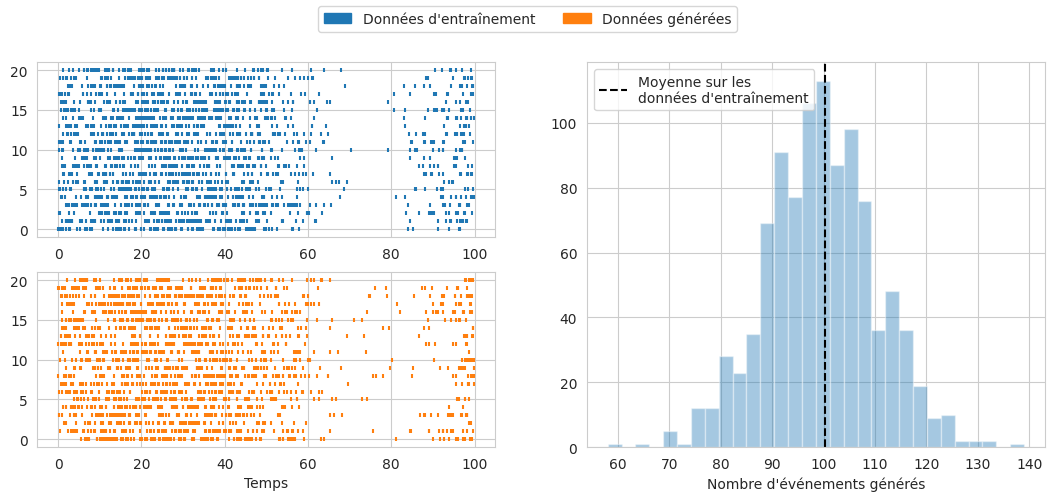

In [168]:
with open('../data/shchur.pkl', 'rb') as f:
    inter_times, seq_lengths, t_end = pickle.load(f)
model = Model.load('../models/shchur_3_gamma.pkl')

arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(1000, t_end)

fig, axes = plt.subplot_mosaic([['top', 'right'], ['bottom', 'right']],
                               figsize=(13, 5))
for i, seq in enumerate(arrival_times):
    t = seq[:seq_lengths[i]]
    axes['top'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C0')
    if i == 20:
        break
left_patch = mpatches.Patch(color='C0', label='Données d\'entraînement')

for i, seq in enumerate(gen_arrival_times):
    t = seq[:gen_seq_lengths[i]]
    axes['bottom'].scatter(
        t, np.ones_like(t) * i, marker='|', s=10, c='C1')
    if i == 20:
        break
right_patch = mpatches.Patch(color='C1', label='Données générées')

axes['right'].hist(gen_seq_lengths, bins=30, alpha=0.4)
axes['right'].axvline(x=np.mean(seq_lengths), color='black', linestyle='--',
                      label='Moyenne sur les\ndonnées d\'entraînement')
axes['right'].legend(loc='upper left')
axes['top'].sharex(axes['bottom'])
axes['bottom'].set_xlabel('Temps')
axes['right'].set_xlabel('Nombre d\'événements générés')
fig.legend(handles=[left_patch, right_patch], loc='upper center', ncol=2)
plt.savefig('../images/gen_data_3_gamma.png', dpi=150, bbox_inches='tight')

In [89]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    batch_size=100, max_len=250, t_end=100)

model = Model(C=32, dist=Gamma, R=32, dropout_rate=0.5, strategy='log_tau')
history = model.fit(inter_times, seq_lengths, t_end, 200,
                    magnitudes, verbose=1)


Loss at epoch    1:   -6.572
Loss at epoch   10:   -9.359
Loss at epoch   20:   -9.514
Loss at epoch   30:   -9.610
Loss at epoch   40:   -9.717
Loss at epoch   50:   -9.783
Loss at epoch   60:   -9.850
Loss at epoch   70:   -9.919
Loss at epoch   80:   -9.990
Loss at epoch   90:  -10.039
Loss at epoch  100:  -10.091
Loss at epoch  110:  -10.124
Loss at epoch  120:  -10.154
Loss at epoch  130:  -10.168
Loss at epoch  140:  -10.182
Loss at epoch  150:  -10.195
Loss at epoch  160:  -10.210
Loss at epoch  170:  -10.224
Loss at epoch  180:  -10.240
Loss at epoch  190:  -10.242
Loss at epoch  200:  -10.256


In [131]:
generated_data, seq_lengths = model.generate(20, np.mean(t_end))

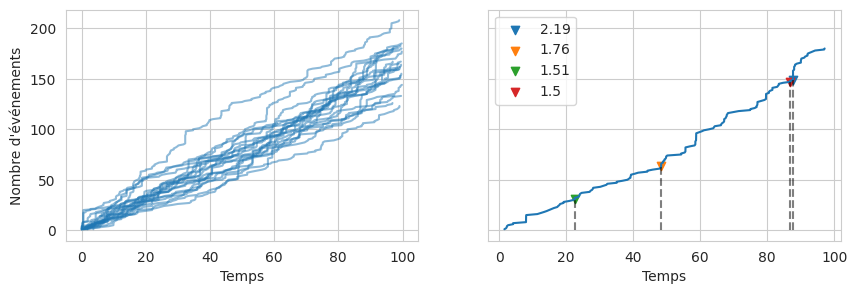

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for i, seq in enumerate(generated_data):
    frame = to_frame(seq).iloc[:seq_lengths[i]]
    axes[0].plot(frame.time, frame.index + 1, color='C0', alpha=0.5)
axes[0].set_xlabel('Temps')
axes[0].set_ylabel('Nombre d\'événements')
i = 9
seq = to_frame(generated_data[i]).iloc[:seq_lengths[i]]
high_mags_idx = seq.magnitude.sort_values(ascending=False).iloc[:4].index
axes[1].plot(seq.time, seq.index + 1)
for idx in high_mags_idx:
    t = seq.time.iloc[idx]
    m = seq.magnitude.iloc[idx]
    axes[1].scatter(t, idx + 1, label=round(m, 2), marker='v')
    axes[1].vlines(t, 0, idx + 1, linestyle='--', color='black', alpha=0.5)
axes[1].legend(loc='upper left')
axes[1].set_xlabel('Temps')
plt.savefig('../images/generated_data.png', bbox_inches='tight', dpi=150)
plt.show()

In [132]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    100, t_end=100, max_len=250, verbose=True)

model = Model(C=32, dist=Weibull, R=3, dropout_rate=.4, strategy='log_tau')
history = model.fit(inter_times, seq_lengths, t_end, 200, magnitudes)

Generating sequences: 100/100
Loss at epoch    1:   -6.578
Loss at epoch   10:   -8.812
Loss at epoch   20:   -9.264
Loss at epoch   30:   -9.494
Loss at epoch   40:   -9.629
Loss at epoch   50:   -9.737
Loss at epoch   60:   -9.831
Loss at epoch   70:   -9.918
Loss at epoch   80:   -9.993
Loss at epoch   90:  -10.064
Loss at epoch  100:  -10.126
Loss at epoch  110:  -10.186
Loss at epoch  120:  -10.236
Loss at epoch  130:  -10.283
Loss at epoch  140:  -10.317
Loss at epoch  150:  -10.342
Loss at epoch  160:  -10.368
Loss at epoch  170:  -10.402
Loss at epoch  180:  -10.421
Loss at epoch  190:  -10.449
Loss at epoch  200:  -10.463


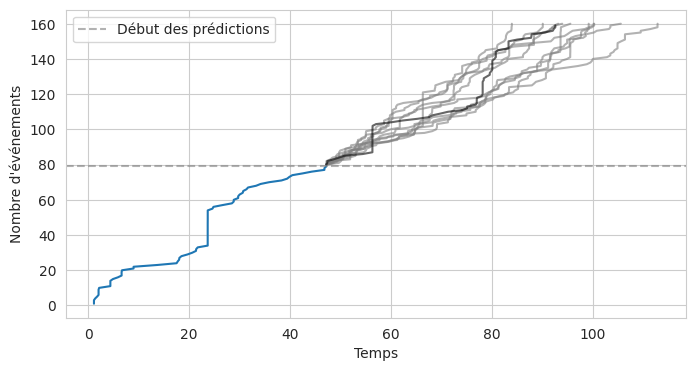

In [152]:
seq = etas(t_end=np.mean(t_end))

n_before = 80
n_preds = 80

past_seq = seq[:-n_before]

fig, ax = plt.subplots(figsize=(8, 4))

t = past_seq[:, 0]
m = past_seq[:, 1]
for i in range(10):
    preds = model.predict(t, m, n_preds)
    t_preds = np.concatenate([[t[-1]], preds[:, 0]])
    m_preds = preds[:, 1]
    ax.plot(t_preds, t.size + cumsum(t_preds), c='gray', alpha=0.6)

seq_size = seq.shape[0]
last_idx_target = min(seq_size - 1, seq_size - n_before + n_preds)
t_targets = seq[-n_before - 1:last_idx_target, 0]

ax.plot(t, cumsum(t))
ax.plot(t_targets, t.size + cumsum(t_targets), alpha=0.6, c='black')
ax.axhline(y=t.size, linestyle='--', c='gray',
           alpha=0.6, label='Début des prédictions')
ax.legend()
ax.set_xlabel('Temps')
ax.set_ylabel('Nombre d\'événements')
plt.savefig('../images/etas_preds.png', bbox_inches='tight', dpi=150)

In [153]:
idx = to_frame(seq).magnitude.sort_values(ascending=False).iloc[:10].index
idx

Index([85, 48, 34, 118, 156, 109, 139, 152, 100, 129], dtype='int64')

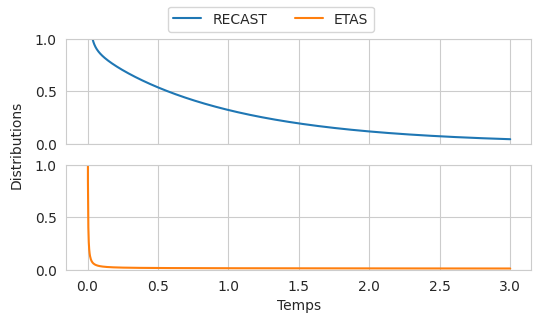

In [165]:
sub_seq = seq[:idx[0]]
t = sub_seq[:, 0]
m = sub_seq[:, 1]

recast_dist = model.predict(t, m, 1, True)[1][0]
etas_dist = ETAS(t, m)

fig, axes = plt.subplots(2, 1, sharex='col', sharey='col', figsize=(6, 3))
x = np.linspace(0, 3, 1000)
axes[0].plot(x, recast_dist.prob(x), label='RECAST')
axes[1].plot(x, etas_dist.prob(x), label='ETAS', c='C1')
axes[1].set_ylim((0, 1))
axes[1].set_xlabel('Temps')
plt.text(-0.55, 0.8, 'Distributions', rotation=90.)
fig.legend(loc='upper center', ncol=2)

plt.savefig('../images/dist_etas_recast_1.png', dpi=150, bbox_inches='tight')

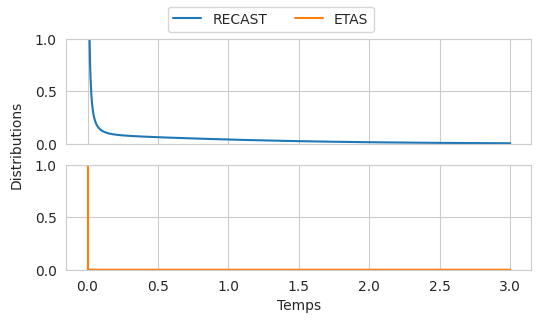

In [166]:
sub_seq = seq[:idx[0] + 1]
t = sub_seq[:, 0]
m = sub_seq[:, 1]

recast_dist = model.predict(t, m, 1, True)[1][0]
etas_dist = ETAS(t, m)

fig, axes = plt.subplots(2, 1, sharex='col', sharey='col', figsize=(6, 3))
x = np.linspace(0, 3, 1000)
axes[0].plot(x, recast_dist.prob(x), label='RECAST')
axes[1].plot(x, etas_dist.prob(x), label='ETAS', c='C1')
axes[1].set_ylim((0, 1))
axes[1].set_xlabel('Temps')
plt.text(-0.55, 0.8, 'Distributions', rotation=90.)
fig.legend(loc='upper center', ncol=2)

plt.savefig('../images/dist_etas_recast_2.png', dpi=150, bbox_inches='tight')